In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.feature_selection import chi2
from sklearn.metrics import cohen_kappa_score



plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

In [3]:
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
1853,3048,2,I believe that all the books are meant to be in the library. People would not want them gone if ...,3,3,NaN,3,4.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
tool = language_check.LanguageTool('en-US')

t0 = datetime.now()

training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
training_set['corrections'] = training_set.apply(lambda l: len(l['matches']), axis=1)
training_set['corrected'] = training_set.apply(lambda l: language_check.correct(l['essay'], l['matches']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))


training_set.to_pickle('training_corr.pkl')

Processing time: 1:16:56.353911


In [2]:
training_set = pd.read_pickle('training_corr.pkl')

In [3]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 

nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

# suppress numpy warnings
np.warnings.filterwarnings('ignore')

for essay in nlp.pipe(training_set['corrected'], batch_size=100, n_threads=3):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))    

Processing time: 0:19:02.203386


In [4]:
training_set.to_pickle('training_spacy.pkl')


In [5]:
training_set.sample(7)

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,matches,corrections,corrected,tokens,lemma,pos,sents,ner
11046,18242,7,One day at the fair I was patient. I wanted to ride the bumper cars. So I got in line. There whe...,9,7,NaN,16,NaN,NaN,NaN,2.0,2.0,2.0,3.0,NaN,NaN,2.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],0,One day at the fair I was patient. I wanted to ride the bumper cars. So I got in line. There whe...,"[One, day, at, the, fair, I, was, patient, ., I, wanted, to, ride, the, bumper, cars, ., So, I, ...","[one, day, at, the, fair, -PRON-, be, patient, ., -PRON-, want, to, ride, the, bumper, car, ., s...","[NUM, NOUN, ADP, DET, NOUN, PRON, AUX, ADJ, PUNCT, PRON, VERB, PART, VERB, DET, NOUN, NOUN, PUNC...","[One day at the fair I was patient., I wanted to ride the bumper cars., So I got in line., There...",[One day]
8849,13597,5,"The mood created @CAPS1 the author in the memoir is a positive and grateful mood for his home, a...",4,3,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Line 1, column 199, Rule ID: EN_QUOTES[1]\nMessage: Use a smart opening quote here: '“'.\nSugge...",10,"The mood created @CAPS1 the author in the memoir is a positive and grateful mood for his home, a...","[The, mood, created, @CAPS1, the, author, in, the, memoir, is, a, positive, and, grateful, mood,...","[the, mood, create, @caps1, the, author, in, the, memoir, be, a, positive, and, grateful, mood, ...","[DET, NOUN, VERB, ADP, DET, NOUN, ADP, DET, NOUN, AUX, DET, ADJ, CCONJ, ADJ, NOUN, ADP, DET, NOU...","[The mood created @CAPS1 the author in the memoir is a positive and grateful mood for his home, ...","[One, Cuban, Cuban]"
3376,4571,2,"When you go to library, you @MONTH1 have a lot choice about reading books, watching movies or li...",3,3,NaN,3,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Line 1, column 168, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found\nS...",20,"When you go to library, you @MONTH1 have a lot choice about reading books, watching movies or li...","[When, you, go, to, library, ,, you, @MONTH1, have, a, lot, choice, about, reading, books, ,, wa...","[when, -PRON-, go, to, library, ,, -PRON-, @month1, have, a, lot, choice, about, read, book, ,, ...","[ADV, PRON, VERB, ADP, NOUN, PUNCT, PRON, NOUN, AUX, DET, NOUN, NOUN, ADP, VERB, NOUN, PUNCT, VE...","[When you go to library, you @MONTH1 have a lot choice about reading books, watching movies or l...","[one, one]"
1359,1364,1,"I agree with the many peole that but benefits society. Computers can be used as a learning tool,...",4,5,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Line 1, column 23, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found\nSu...",15,I agree with the many people that but benefits society. Computers can be used as a learning tool...,"[I, agree, with, the, many, people, that, but, benefits, society, ., Computers, can, be, used, a...","[-PRON-, agree, with, the, many, people, that, but, benefit, society, ., computer, can, be, use,...","[PRON, VERB, ADP, DET, ADJ, NOUN, DET, CCONJ, VERB, NOUN, PUNCT, NOUN, VERB, AUX, VERB, SCONJ, D...","[I agree with the many people that but benefits society., Computers can be used as a learning to...","[First, Facebook]"
6366,9923,4,The author concludes the story with that paragraph because it shows that character will retry wh...,1,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Line 1, column 167, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found\nS...",1,Th

In [8]:
"""Choose arbitrary essay from highest available target_score for each topic.
all other essays will be compared to these. 
The uncorrected essays will be used since the reference essays should have fewer errors.
"""
reference_essays = {1: 161, 2: 3022, 3: 5263, 4: 5341, 5: 7209, 6: 8896, 7: 11796, 8: 12340} # topic: essay_id

references = {}

t0 = datetime.now()

nlp = spacy.load('en_core_web_sm')
stop_words = set(STOP_WORDS)

# generate nlp object for reference essays:
for topic, index in reference_essays.items():
    references[topic] = nlp(training_set.iloc[index]['essay'])

# generate document similarity for each essay compared to topic reference
training_set['similarity'] = training_set.apply(lambda row: nlp(row['essay']).similarity(references[row['topic']]), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:11:33.861803


In [9]:
t0 = datetime.now()

training_set['token_count'] = training_set.apply(lambda x: len(x['tokens']), axis=1)
training_set['unique_token_count'] = training_set.apply(lambda x: len(set(x['tokens'])), axis=1)
training_set['nostop_count'] = training_set \
            .apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
training_set['sent_count'] = training_set.apply(lambda x: len(x['sents']), axis=1)
training_set['ner_count'] = training_set.apply(lambda x: len(x['ner']), axis=1)
    training_set['comma'] = training_set.apply(lambda x: x['corrected'].count(','), axis=1)
training_set['question'] = training_set.apply(lambda x: x['corrected'].count('?'), axis=1)
training_set['exclamation'] = training_set.apply(lambda x: x['corrected'].count('!'), axis=1)
training_set['quotation'] = training_set.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
training_set['organization'] = training_set.apply(lambda x: x['corrected'].count(r'@ORGANIZATION'), axis=1)
training_set['caps'] = training_set.apply(lambda x: x['corrected'].count(r'@CAPS'), axis=1)
training_set['person'] = training_set.apply(lambda x: x['corrected'].count(r'@PERSON'), axis=1)
training_set['location'] = training_set.apply(lambda x: x['corrected'].count(r'@LOCATION'), axis=1)
training_set['money'] = training_set.apply(lambda x: x['corrected'].count(r'@MONEY'), axis=1)
training_set['time'] = training_set.apply(lambda x: x['corrected'].count(r'@TIME'), axis=1)
training_set['date'] = training_set.apply(lambda x: x['corrected'].count(r'@DATE'), axis=1)
training_set['percent'] = training_set.apply(lambda x: x['corrected'].count(r'@PERCENT'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['adj'] = training_set.apply(lambda x: x['pos'].count('ADJ'), axis=1)
training_set['pron'] = training_set.apply(lambda x: x['pos'].count('PRON'), axis=1)
training_set['verb'] = training_set.apply(lambda x: x['pos'].count('VERB'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['cconj'] = training_set.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
training_set['adv'] = training_set.apply(lambda x: x['pos'].count('ADV'), axis=1)
training_set['det'] = training_set.apply(lambda x: x['pos'].count('DET'), axis=1)
training_set['propn'] = training_set.apply(lambda x: x['pos'].count('PROPN'), axis=1)
training_set['num'] = training_set.apply(lambda x: x['pos'].count('NUM'), axis=1)
training_set['part'] = training_set.apply(lambda x: x['pos'].count('PART'), axis=1)
training_set['intj'] = training_set.apply(lambda x: x['pos'].count('INTJ'), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))
training_set.to_pickle('training_features.pkl')

Processing time: 0:00:08.153309


In [11]:
training_set['matches'][0]

[Match({'fromy': 0, 'fromx': 218, 'toy': 0, 'tox': 224, 'ruleId': 'MORFOLOGIK_RULE_EN_US', 'msg': 'Possible spelling mistake found', 'replacements': ['trouble', 'treble'], 'context': '...he globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How wo...', 'contextoffset': 43, 'offset': 218, 'errorlength': 6, 'category': 'Possible Typo', 'locqualityissuetype': 'misspelling'}),
 Match({'fromy': 0, 'fromx': 239, 'toy': 0, 'tox': 243, 'ruleId': 'EN_CONTRACTION_SPELLING', 'msg': 'Possible spelling mistake found', 'replacements': ["Don't"], 'context': '...nd keeps us out of troble! Thing about! Dont you think so? How would you feel if you...', 'contextoffset': 43, 'offset': 239, 'errorlength': 4, 'category': 'Possible Typo', 'locqualityissuetype': 'misspelling'}),
 Match({'fromy': 0, 'fromx': 377, 'toy': 0, 'tox': 385, 'ruleId': 'MORFOLOGIK_RULE_EN_US', 'msg': 'Possible spelling mistake found', 'replacements': ['business'], 'context': "... ever time to chat with your f

In [12]:
training_set['corrected'][0]

"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of trouble! Thing about! Don't you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or business partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, Facebook, MySpace act. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countries/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the eco

In [13]:
training_set['tokens'][0]

['Dear',
 'local',
 'newspaper',
 ',',
 'I',
 'think',
 'effects',
 'computers',
 'have',
 'on',
 'people',
 'are',
 'great',
 'learning',
 'skills',
 '/',
 'affects',
 'because',
 'they',
 'give',
 'us',
 'time',
 'to',
 'chat',
 'with',
 'friends',
 '/',
 'new',
 'people',
 ',',
 'helps',
 'us',
 'learn',
 'about',
 'the',
 'globe(astronomy',
 ')',
 'and',
 'keeps',
 'us',
 'out',
 'of',
 'trouble',
 '!',
 'Thing',
 'about',
 '!',
 'Do',
 "n't",
 'you',
 'think',
 'so',
 '?',
 'How',
 'would',
 'you',
 'feel',
 'if',
 'your',
 'teenager',
 'is',
 'always',
 'on',
 'the',
 'phone',
 'with',
 'friends',
 '!',
 'Do',
 'you',
 'ever',
 'time',
 'to',
 'chat',
 'with',
 'your',
 'friends',
 'or',
 'business',
 'partner',
 'about',
 'things',
 '.',
 'Well',
 'now',
 '-',
 'there',
 "'s",
 'a',
 'new',
 'way',
 'to',
 'chat',
 'the',
 'computer',
 ',',
 'theirs',
 'plenty',
 'of',
 'sites',
 'on',
 'the',
 'internet',
 'to',
 'do',
 'so',
 ':',
 '@ORGANIZATION1',
 ',',
 '@ORGANIZATION2',
 '

In [14]:
training_set['lemma'][0]

['dear',
 'local',
 'newspaper',
 ',',
 '-PRON-',
 'think',
 'effect',
 'computer',
 'have',
 'on',
 'people',
 'be',
 'great',
 'learning',
 'skill',
 '/',
 'affect',
 'because',
 '-PRON-',
 'give',
 '-PRON-',
 'time',
 'to',
 'chat',
 'with',
 'friend',
 '/',
 'new',
 'people',
 ',',
 'help',
 '-PRON-',
 'learn',
 'about',
 'the',
 'globe(astronomy',
 ')',
 'and',
 'keep',
 '-PRON-',
 'out',
 'of',
 'trouble',
 '!',
 'thing',
 'about',
 '!',
 'do',
 'not',
 '-PRON-',
 'think',
 'so',
 '?',
 'how',
 'would',
 '-PRON-',
 'feel',
 'if',
 '-PRON-',
 'teenager',
 'be',
 'always',
 'on',
 'the',
 'phone',
 'with',
 'friend',
 '!',
 'do',
 '-PRON-',
 'ever',
 'time',
 'to',
 'chat',
 'with',
 '-PRON-',
 'friend',
 'or',
 'business',
 'partner',
 'about',
 'thing',
 '.',
 'well',
 'now',
 '-',
 'there',
 'be',
 'a',
 'new',
 'way',
 'to',
 'chat',
 'the',
 'computer',
 ',',
 '-PRON-',
 'plenty',
 'of',
 'site',
 'on',
 'the',
 'internet',
 'to',
 'do',
 'so',
 ':',
 '@ORGANIZATION1',
 ',',
 

In [16]:
training_set['ner'][0]

['Facebook', '@DATE1', 'all day']

In [4]:
training_set = pd.read_pickle('training_features.pkl')

In [37]:
training_set.columns

Index(['essay_id', 'topic', 'essay', 'rater1_domain1', 'rater2_domain1', 'rater3_domain1', 'target_score', 'rater1_domain2', 'rater2_domain2', 'topic2_target', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6', 'matches', 'corrections',
       'corrected', 'tokens', 'lemma', 'pos', 'sents', 'ner', 'similarity', 'token_count', 'unique_token_count', 'nostop_count', 'sent_count', 'ner_count', 'comma', 'question', 'exclamation', 'quotation', 'organization', 'caps', 'person', 'location', 'money', 'time', 'date', 'percent', 'noun', 'adj', 'pron', 'verb', 'cconj', 'adv', 'det', 'propn', 'num', 'part', 'intj'],
      dtype='object')

In [5]:
training_set=training_set.drop(columns=['rater1_domain1','rater2_domain1','essay_id','rater3_domain1','rater1_domain2','rater2_domain2','rater1_trait1','rater1_trait2','rater1_trait3','rater1_trait4','rater1_trait5','rater1_trait6','rater2_trait1','rater2_trait2','rater2_trait3','rater2_trait4','rater2_trait5','rater2_trait6','rater3_trait1','rater3_trait2','rater3_trait3','rater3_trait4','rater3_trait5','rater3_trait6'])
training_set.sample(7)

,topic,essay,target_score,topic2_target,matches,corrections,corrected,tokens,lemma,pos,sents,ner,similarity,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,exclamation,quotation,organization,caps,person,location,money,time,date,percent,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj
6746,4,"In the story Winter Hibiscus by Minfong Ho, the main character Saeng who moved to @LOCATION1 f...",3,NaN,"[Line 1, column 14, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found\nSu...",16,"In the story winter Hibiscus by Mining Ho, the main character Sang who moved to @LOCATION1 from ...","[In, the, story, winter, Hibiscus, by, Mining, Ho, ,, the, main, character, Sang, who, moved, to...","[in, the, story, winter, Hibiscus, by, Mining, Ho, ,, the, main, character, Sang, who, move, to,...","[ADP, DET, NOUN, NOUN, PROPN, ADP, PROPN, PROPN, PUNCT, DET, ADJ, NOUN, PROPN, PRON, VERB, ADP, ...","[In the story winter Hibiscus by Mining Ho,, the main character Sang who moved to @LOCATION1 fro...","[winter, Hibiscus, Mining Ho, Sang, Vietnam, Vietnam, winter, Hibiscus, the spring]",0.884058,215,101,113,10,9,7,0,0,0,0,0,0,1,0,0,0,0,35,6,16,36,4,11,30,13,0,9,0
854,1,"Dear @CAPS1 @CAPS2 Newspaper, Have you ever wanted to see your @CAPS3 that lives across the coun...",8,NaN,"[Line 1, column 130, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found\nS...",9,"Dear @CAPS1 @CAPS2 Newspaper, Have you ever wanted to see your @CAPS3 that lives across the coun...","[Dear, @CAPS1, @CAPS2, Newspaper, ,, Have, you, ever, wanted, to, see, your, @CAPS3, that, lives...","[dear, @CAPS1, @CAPS2, newspaper, ,, have, -PRON-, ever, want, to, see, -PRON-, @caps3, that, li...","[ADJ, PUNCT, PUNCT, NOUN, PUNCT, AUX, PRON, ADV, VERB, PART, VERB, DET, NOUN, DET, VERB, ADP, DE...","[Dear @CAPS1 @CAPS2 Newspaper, Have you ever wanted to see your @CAPS3 that lives across the cou...",[],0.929117,196,116,93,14,0,3,1,0,1,0,7,0,1,0,0,0,0,38,9,19,38,8,10,18,1,0,4,1
6231,4,The last paragraph of Winter Hibiscus describes determination and the growth of a person. Saen...,2,NaN,"[Line 1, column 23, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found\nSu...",9,The last paragraph of winter Hibiscus describes determination and the growth of a person. Sang s...,"[The, last, paragraph, of, winter, Hibiscus, describes, determination, and, the, growth, of, a, ...","[the, last, paragraph, of, winter, Hibiscus, describe, determination, and, the, growth, of, a, p...","[DET, ADJ, NOUN, ADP, NOUN, PROPN, VERB, NOUN, CCONJ, DET, NOUN, ADP, DET, NOUN, PUNCT, PROPN, V...","[The last paragraph of winter Hibiscus describes determination and the growth of a person., Sang...","[winter, Hibiscus, this hibiscus, again., Just as the hibiscus, Sang, The next season]",0.933691,104,67,56,5,7,2,0,0,0,0,0,0,0,0,0,0,0,19,5,3,21,3,5,14,4,0,4,0
8880,5,The mood was created by the author in the memoir and specic imformationI @CAPS1 the mood is like...,0,NaN,"[Line 1, column 54, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found\nSu...",2,The mood was created by the author in the memoir and specie information @CAPS1 the mood is like ...,"[The, mood, was, created, by, the, author, in, the, memoir, and, specie, information, @CAPS1, th...","[the, mood, be, create, by, the, author, in, the, memoir, and, specie, information, @CAPS1, the,...","[DET, NOUN, AUX, VERB, ADP, DET, NOUN, ADP, DET, NOUN, CCONJ, ADJ, NOUN, PUNCT, DET, NOUN, AUX, ...","[The mood was created by the author in the memoir and specie information @CAPS1, the mood is lik...",[],0.807350,31,23,15,3,0,0,0,0,1,0,2,0,0,0,0,0,0,7,1,2,2,1,1,7,0,0,0,0
2316,2,"Many of us have been at the library once in our life time, but have you ever had a day when you ...",3,3.0,"[Line 1, column 49, Rule ID: LIFE_TIME[1]\nMessage: Did you mean 'lifetime'?\nSuggestion: lifeti...",11,"Many of us have been at the library once in our lifetime, but have you eve

## Feature Selection


In [7]:
predictors = [  'corrections',
                'similarity',
                'unique_token_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]

In [18]:
X=training_set[predictors]
y=training_set['target_score']
best_features= SelectKBest(score_func=chi2,k=10)
fit=best_features.fit(X,y)

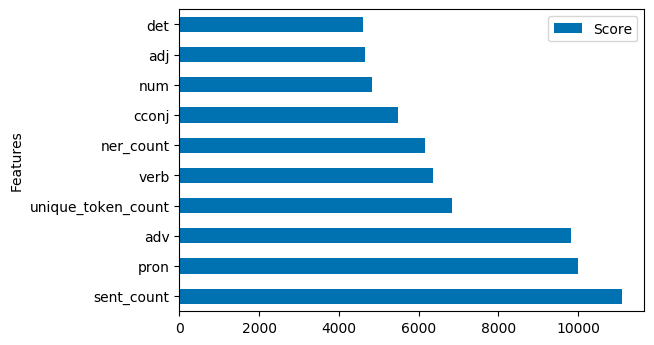

In [29]:
df_score=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,df_score],axis=1)
featureScores.columns=['Features','Score']
featureScores=featureScores.set_index('Features')
featureScores.nlargest(10,'Score').plot(kind='barh')
plt.show()

When the All the essays are taken in whole the best features are stated above let us take now the features for all the topics

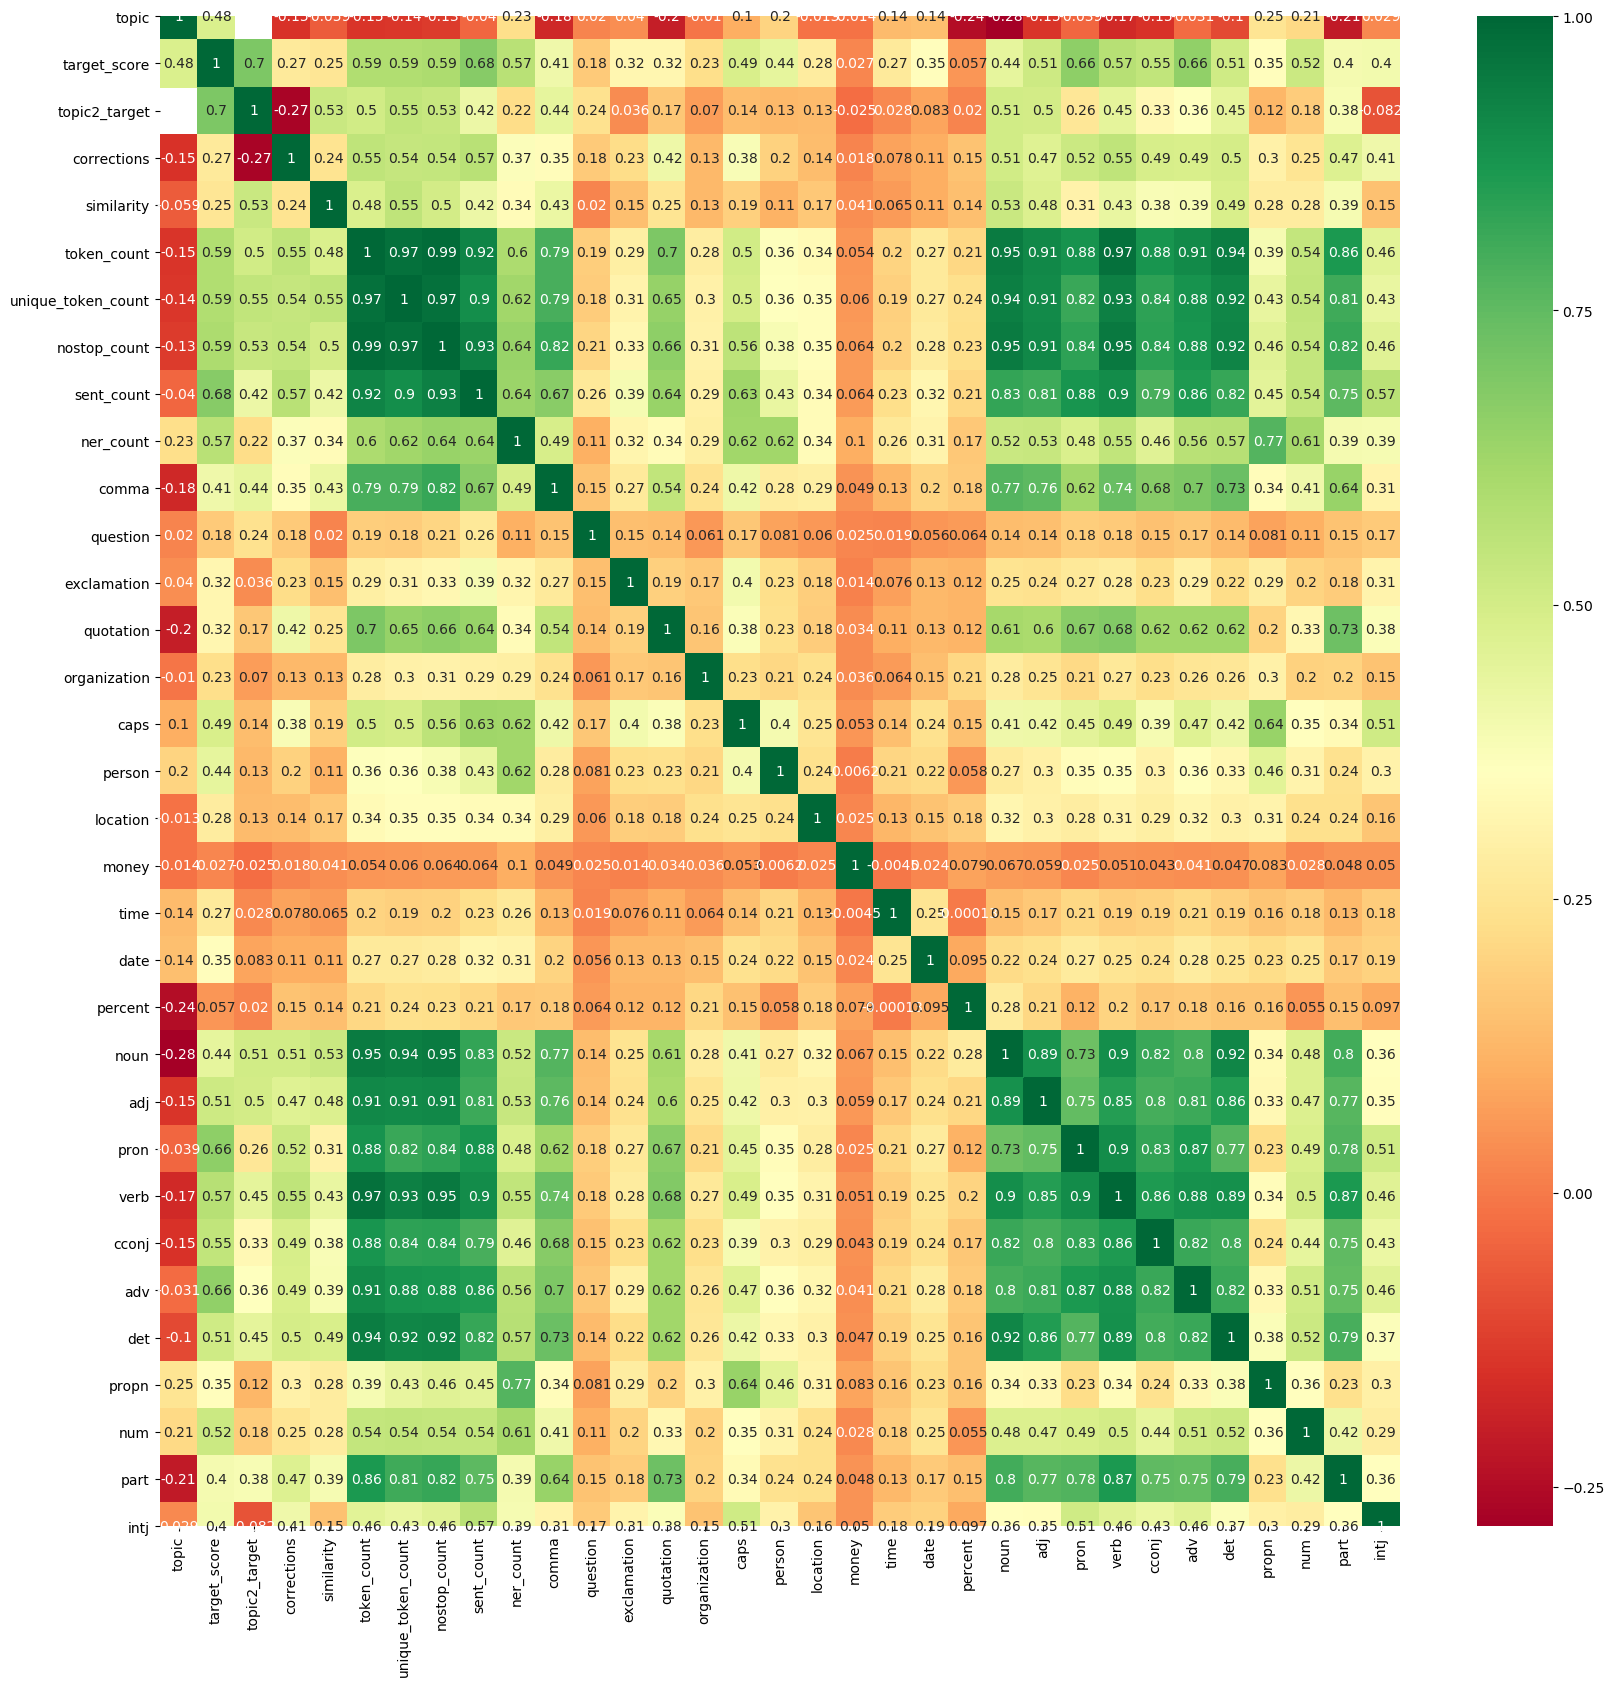

In [42]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = training_set.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(training_set[top_corr_features].corr(),annot=True,cmap="RdYlGn")

The target_score is Least Coorelated with the percent,money,features so we can deduct them from the list of the predictor columns

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

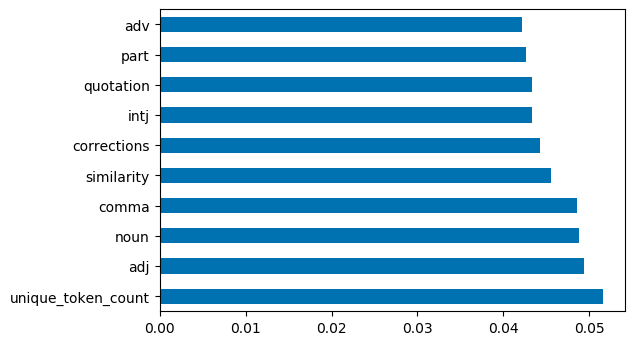

In [44]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [46]:
training_set.shape

(12976, 41)

In [8]:
selector = SelectKBest(f_regression, k=10) 


df = pd.DataFrame()

for topic in range(1, 9):
    kpredictors = []
    
    
    for p in predictors:
        if np.std(training_set[training_set.topic == topic][p], axis=0) != 0:
            kpredictors.append(p)
            
    
    X = training_set[training_set.topic == topic][kpredictors]
    y = training_set[training_set.topic == topic].target_score
    
    selector.fit(X, y)

    
    mask = selector.get_support(indices=True)

    selected_features = training_set[training_set.topic == topic][predictors].columns[mask]
    df["Topic " + str(topic)] = selected_features
df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,similarity,similarity,similarity,unique_token_count,similarity,similarity,similarity,similarity
1,unique_token_count,unique_token_count,unique_token_count,sent_count,unique_token_count,unique_token_count,unique_token_count,unique_token_count
2,sent_count,sent_count,sent_count,comma,sent_count,sent_count,sent_count,sent_count
3,comma,comma,comma,percent,comma,comma,ner_count,comma
4,noun,noun,date,noun,date,date,noun,noun
5,adj,adj,percent,pron,percent,percent,adj,adj
6,verb,verb,adj,verb,adj,adj,pron,verb
7,cconj,adv,pron,cconj,pron,verb,verb,adv
8,adv,det,verb,adv,verb,cconj,adv,det
9,det,part,cconj,det,cconj,adv,det,part


In [11]:
def evaluate(df, topic, features, model):
    """Regression pipeline with kappa evaluation"""

    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    pipeline = Pipeline(model)
    pipeline.fit(X_train, y_train)

    
    y_pred = pipeline.predict(X_test)

    return quadratic_weighted_kappa(y_pred, y_test)

In [14]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator
def mean_quadratic_weighted_kappa(kappas, weights=None):
    """
    Calculates the mean of the quadratic
    weighted kappas after applying Fisher's r-to-z transform, which is
    approximately a variance-stabilizing transformation.  This
    transformation is undefined if one of the kappas is 1.0, so all kappa
    values are capped in the range (-0.999, 0.999).  The reverse
    transformation is then applied before returning the result.
    mean_quadratic_weighted_kappa(kappas), where kappas is a vector of
    kappa values
    mean_quadratic_weighted_kappa(kappas, weights), where weights is a vector
    of weights that is the same size as kappas.  Weights are applied in the
    z-space
    """
    kappas = np.array(kappas, dtype=float)
    if weights is None:
        weights = np.ones(np.shape(kappas))
    else:
        weights = weights / np.mean(weights)

    # ensure that kappas are in the range [-.999, .999]
    kappas = np.array([min(x, .999) for x in kappas])
    kappas = np.array([max(x, -.999) for x in kappas])

    z = 0.5 * np.log((1 + kappas) / (1 - kappas)) * weights
    z = np.mean(z)
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

In [17]:
predictors = [  
                
                'corrections',
                'similarity',
                'token_count',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]
models = [
            [('scaler', StandardScaler()),('linearSVC', LinearSVC(C=0.01))] ,
            [('scaler', StandardScaler()),('lm', LinearRegression())], 
            [('rf', RandomForestRegressor(random_state=26))],  
            [('en', ElasticNet(l1_ratio=0.01, alpha=0.1, max_iter=100000, random_state=26))] 
        ]

for steps in models:
    kappas = []
    weights = []
    for topic in range(1,9):
        kappas.append(evaluate(training_set, topic, predictors, steps))
        weights.append(len(training_set[training_set.topic==topic]))

    mqwk = mean_quadratic_weighted_kappa(kappas, weights)
    print(steps)
    print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))
    print('')

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearSVC', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]
Weighted by topic Kappa score: 0.5776

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))]
Weighted by topic Kappa score: 0.6356



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=26, verbose=0,
                      warm_start=False))]
Weighted by topic Kappa score: 0.6373

[('en', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.01,
           max_iter=100000, normalize=False, positive=False, precompute=False,
           random_state=26, selection='cyclic', tol=0.0001, warm_start=False))]
Weighted by topic Kappa score: 0.6265



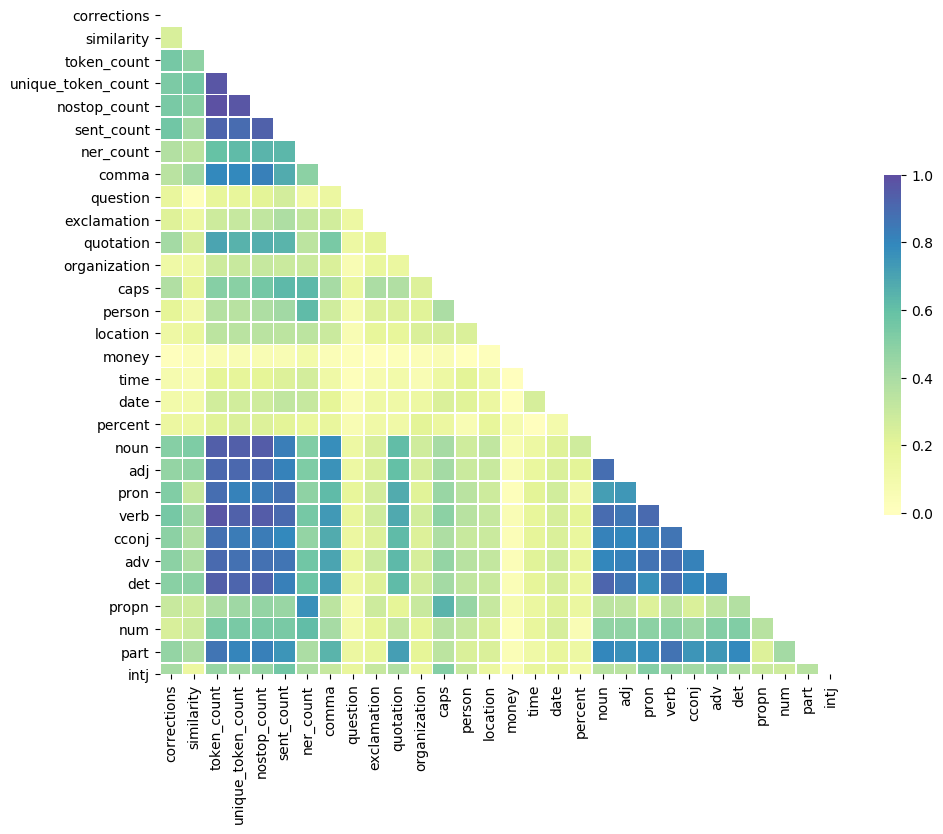

In [18]:
corr = training_set[predictors].corr() # default: Pearson
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap='Spectral', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [19]:
training_set['l_essay'] = training_set['lemma'].apply(' '.join)

vectorizer = TfidfVectorizer(max_df=.2, 
                             min_df=3, 
                             max_features=2000,
                             stop_words=STOP_WORDS) # default: binary=False
tfidf_matrix = vectorizer.fit_transform(training_set.l_essay) # using lemmatized essays
tfidf_matrix.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(12976, 2000)

In [20]:
combined_dense = pd.concat([pd.DataFrame(tfidf_matrix.todense()), 
                            training_set[predictors], 
                            training_set['topic'], 
                            training_set['target_score']], axis=1)
combined_dense.shape


(12976, 2032)

In [23]:
def tf_evaluate(df, topic):
    # Regression pipeline with kappa evaluation
    paramgrid = {'l1_ratio': [.01, .1, .5, .9], 'alpha': [0.01, .1, 1]}
    X = df[df['topic'] == topic].drop(['topic', 'target_score'], axis=1)
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    gs = GridSearchCV(ElasticNet(max_iter=100000, random_state=26),param_grid=paramgrid,cv=5)
    gs.fit(X_train, y_train)
    print('Topic', topic, 'best parameters:', gs.best_params_)
    y_pred = gs.predict(X_test)
    
    return quadratic_weighted_kappa(y_pred, y_test)

In [24]:
kappas = []
weights = []
for topic in range(1,9):
    kappas.append(tf_evaluate(combined_dense, topic))
    weights.append(len(training_set[training_set.topic==topic]))
    
mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Topic 1 best parameters: {'alpha': 1, 'l1_ratio': 0.1}
Topic 2 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 3 best parameters: {'alpha': 0.1, 'l1_ratio': 0.5}
Topic 4 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 5 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 6 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 7 best parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Topic 8 best parameters: {'alpha': 1, 'l1_ratio': 0.9}
Weighted by topic Kappa score: 0.6466
